In [1]:
import os
import io
import gc
import sys
import yaml
import time
import glob
import wave
import faiss

import random
import librosa

import numpy as np
import pandas as pd
import deepdish as dd
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from model_RA.fp_RA.nnfp import get_fingerprinter
from model_RA.fp_RA.melspec.melspectrogram_RA import get_melspec_layer

2024-07-12 11:34:45.624497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Carregar Faiss Index**

In [2]:
def create_index(db_embeddings, nogpu=True, n_centroids=256, code_sz=64, nbits=8):
    #faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits), com d=, nlist=n_centroids=50, m=code_sz=8, bits=nbits=8
    #faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
    #n_centroids -> clusters

    # GPU Setup
    if not nogpu:
        GPU_RESOURCES = faiss.StandardGpuResources()
        GPU_OPTIONS = faiss.GpuClonerOptions()
        GPU_OPTIONS.useFloat16 = True # use float16 table to avoid https://github.com/facebookresearch/faiss/issues/1178
    else:
        pass
    

    # Fingerprint dimension, d
    d = db_embeddings.shape[1] #len(db_embeddings[0][0]) #db_embeddings.shape[1]  # Dim emb #len(db_embeddings[0][0][0])


    # Build a flat (CPU) index
    quantizer = faiss.IndexFlatL2(d)


    # Using IVF-PQ index
    code_sz = 64 # power of 2
    n_centroids = 256 # Number of Veronoi Cells (?)
    nbits = 8  # nbits must be 8, 12 or 16, The dimension d should be a multiple of M.
    index = faiss.IndexIVFPQ(quantizer, d, n_centroids, code_sz, nbits) #Adicona clustering


    # Se não usar GPU
    if not nogpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    max_nitem_train = int(1e7)
    # Train index
    if not index.is_trained:
        #print('Training index using {:>3.2f} % of data...'.format(100. * max_nitem_train / len(db_embeddings)))
        #sel_tr_idx = np.random.permutation(len(db_embeddings))
        #sel_tr_idx = sel_tr_idx[:max_nitem_train]
        #index.train(db_embeddings[sel_tr_idx,:])
        index.train(db_embeddings)
    

    # N probe
    index.nprobe = 40
    return index

# **Carregar Base de Dados**

In [3]:
def def_files(files, train_num):
    embs = []

    for _, file in enumerate(files):
        embs.append(dd.io.load(file))

    embs = np.concatenate(embs, axis=0)
    sel_tr_idx = np.random.permutation(len(embs))
    sel_tr_idx = sel_tr_idx[:train_num]

    return embs, sel_tr_idx

In [4]:
#carregar em duas parcelas devido aos problemas de memória
source_dir = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dummyEmb/'
h5Files = sorted(glob.glob(os.path.join(source_dir, '**/*.h5') ,recursive = True))


mid_file = len(h5Files)//2
h5Files_1 = h5Files[:mid_file]
h5Files_2 = h5Files[mid_file:]
files = [h5Files_1, h5Files_2]



max_train_num = int(1e7)
idx_1_train = idx_2_train = np.empty((max_train_num//2, 128))


embs_1, idx_1_train = def_files(files[0], max_train_num//2)
print(len(embs_1))
embs_1_sliced = embs_1[idx_1_train,:]
del embs_1, idx_1_train

embs_2, idx_2_train = def_files(files[1], max_train_num//2)
print(len(embs_2))
embs_2_sliced = embs_2[idx_2_train,:]
del embs_2, idx_2_train

embs_sliced = np.concatenate((embs_1_sliced, embs_2_sliced), axis = 0)
del embs_1_sliced, embs_2_sliced

In [ ]:
%%time
faiss_engine = create_index(embs_sliced, nogpu=True, n_centroids=256, code_sz=64, nbits=8) #dummy_db

## **Carrega Informações da Base de Dados**

In [ ]:
def add_faiss(faiss_engine, h5Files):
    for idx_file, file in enumerate(h5Files):
        print(file)
        emb = dd.io.load(file)
        faiss_engine.add(emb)
    
    return faiss_engine

### **dummy**

In [ ]:
%%time
#2h 42min 36s
source_dir = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dummyEmb/'
h5Files_dummy = sorted(glob.glob(os.path.join(source_dir, '**/*.h5') ,recursive = True)) #93458 files

#93458 ficheiros/músicas

for idx_file, file in enumerate(h5Files_dummy):
        print(file)
        emb = dd.io.load(file)
        faiss_engine.add(emb)

### **db**

In [ ]:
source_dir_db = '/mnt/dataset/public/Fingerprinting/Embeddings_BFTRI/dbEmb/'
h5Files_db = sorted(glob.glob(os.path.join(source_dir_db, '**/*.h5') ,recursive = True))

#93458 ficheiros/músicas

for idx_file, file in enumerate(h5Files_db):
    print(file)
    emb = dd.io.load(file)
    faiss_engine.add(emb)

#### **Nomes das Músicas**

In [ ]:
"""
def musica(music_names, pred_ids, idx_music):
    tracksCSV = '/mnt/dataset/public/Fingerprinting/selected_tracks.csv'
    df = pd.read_csv(tracksCSV)

    music_names = np.array(music_names)

    map_obra = lambda idx: music_names[idx]

    obras_result = map_obra(pred_ids[idx_music])

    print(obras_result)

    linha_encontrada = df[df.iloc[:, 0] == int(obras_result)]

    return linha_encontrada
"""

# **Carrega Modelo**

In [ ]:
def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

In [ ]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_fp


@tf.function
def predict(X, m_pre, m_fp):
    """ 
    Test step used for mini-search-validation 
    X -> (B,1,8000)
    """
    #tf.print(X)
    feat = m_pre(X)  # (nA+nP, F, T, 1)
    m_fp.trainable = False
    emb_f = m_fp.front_conv(feat)  # (BSZ, Dim)
    emb_gf = m_fp.div_enc(emb_f)
    emb_gf = tf.math.l2_normalize(emb_gf, axis=1)
    
    return emb_gf # L2(g(f(.))

In [ ]:
config = "default_RA"
cfg = load_config(config)

m_pre, m_fp = build_fp(cfg)

checkpoint_root_dir:str = "./logs/CHECK_BFTRI_100/101/"
checkpoint = tf.train.Checkpoint(m_fp)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_root_dir))

cli: Configuration from ./config/default_RA.yaml


# **Carrega Query**

In [ ]:
def convert_to_wav(audio_file_path, wav_file_path, sample_rate=8000):
    file_extension = os.path.splitext(audio_file_path)[1][1:].lower()

    if file_extension in ['mp3', 'wav', 'ogg', 'flv', 'flac', 'mp4', 'wma', 'aac', 'aiff', 'au']:
        audio = AudioSegment.from_file(audio_file_path, format=file_extension)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    audio = audio.set_frame_rate(sample_rate)

    audio.export(wav_file_path, format="wav")

In [ ]:
def convert_to_wav_bytes(audio_file_path, sample_rate=8000):
    # Descobrir a extensão do arquivo de entrada
    file_extension = os.path.splitext(audio_file_path)[1][1:].lower()
    
    # Carregar o arquivo de áudio com base na extensão
    if file_extension in ['mp3', 'wav', 'ogg', 'flv', 'flac', 'mp4', 'wma', 'aac', 'aiff', 'au']:
        audio = AudioSegment.from_file(audio_file_path, format=file_extension)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    # Configurar a taxa de amostragem
    audio = audio.set_frame_rate(sample_rate)
    
    # Exportar o arquivo como bytes WAV
    wav_io = io.BytesIO()
    audio.export(wav_io, format="wav")
    wav_io.seek(0)
    
    return wav_io.read()

In [ ]:
def plot_waveform(audio):
    sample_rate=8000
    # Plotar a forma de onda do áudio
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio, sr=sample_rate)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
def get_audio(audiofile, sr_target=8000):
    audio, fs = librosa.load(audiofile, mono=True, sr=sr_target)
    return audio, fs

def nframe(audio, win_size, hop_size):
    frames =librosa.util.frame(x=audio, frame_length=win_size, hop_length=hop_size)
    return frames

In [ ]:
def get_embeddings(file, win_size_sec, hop_size_sec):
    emb_list = []

    _, file_extension = os.path.splitext(file)

    if file_extension == '.wav':
        audio, fs = get_audio(audiofile=file)
        plot_waveform(audio)
    else:
        audio = convert_to_wav_bytes(file, sample_rate=8000)
        audio, fs = get_audio(io.BytesIO(audio), sr_target=8000)
        plot_waveform(audio)


    audio_frames = nframe(audio, int(win_size_sec * fs), int(hop_size_sec*fs))
    audio_frames = np.transpose(audio_frames[np.newaxis, ...], (2, 0,1))
    
    
    # b) gerar o embedded
    emb = predict(audio_frames, m_pre, m_fp) # tensor 1 - TensorShape([473, 128])
    emb = emb.numpy() # tensor 1 - (473, 128)

    emb_list.append(emb)
    
    return np.concatenate(emb_list, axis = 0)

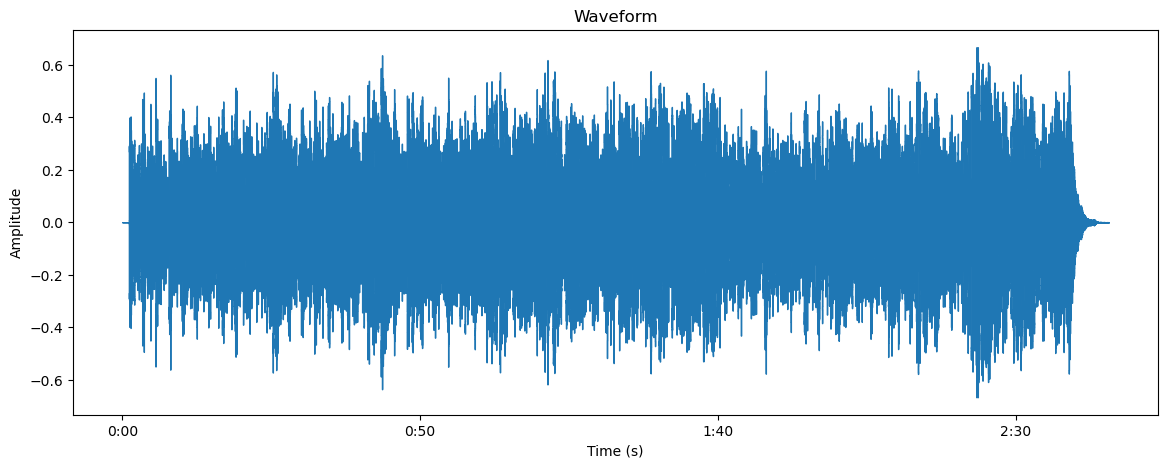

CPU times: user 15.5 s, sys: 2.39 s, total: 17.9 s
Wall time: 5.25 s


In [ ]:
%%time
#a) carregar áudio
queryDir = '/mnt/dataset/public/Fingerprinting/FalseBD/eterna-cancao-wav-12569.wav'
queryDir ='/home/rodrigo/Downloads/eterna-cancao-wav-12569.mp3'
queryFile = glob.glob(os.path.join(queryDir) ,recursive = True)

win_size_sec = 1
hop_size_sec = 0.5

queryEmbeddings = get_embeddings(queryFile[0], win_size_sec, hop_size_sec)

### **Procura Query**

In [ ]:
def  get_threshold(q_shape_0, query_length_limiar):

    query_length_limiar = {
        1: 0.852932, #0.852932,
        3: 0.2,
        5: 0.05,
        9: 0.03,
        11: 0.02,
        19: 0.006
        }

    valid_keys = [key for key in query_length_limiar.keys() if key <= q_shape_0]

    if valid_keys:
        # Selecionar a maior dessas chaves
        selected_key = max(valid_keys)
        return query_length_limiar[selected_key]

In [ ]:
db_startIndex = 53754198
q = queryEmbeddings
sl = q.shape[0] #query length

In [ ]:
%%time
_, I = faiss_engine.search(q, 20) # D: Distâncias, I: Índices dos resultados

In [ ]:
for offset in range(len(I)):
    I[offset, :] -= offset


candidates = np.unique(I[np.where(I >= 0)])   # ignore id < 0


# Sequence match score 
_scores = np.zeros(len(candidates))
for ci, cid in enumerate(candidates):
    _scores[ci] = np.mean(
        np.diag(
            np.dot(q, fake_recon_index[cid:cid + q.shape[0], :].T)
            )
        )

# Evaluate 
pred_ids = candidates[np.argsort(-_scores)[:10]]

threshold = get_threshold(sl)

for i, pred_id in enumerate(pred_ids):
    if sorted(_scores)[i:i+1][0] < threshold and sorted(_scores)[i:i+1][0] > 0: #verificar se este último é realmente verdade
        musica_encontrada = musica(music_names, pred_ids, 0)
        print(musica_encontrada)
        break
    
    if i == len(pred_ids)-1:
        print("Não encontrou a música.")